# Aurora Inference Using Triton Server

This Jupyter Notebook demonstrates how to perform inference using the Aurora foundation model deployed on a Triton Inference Server. It walks through the end-to-end process of formatting inputs, sending requests to the server, and retrieving model predictions. The notebook is designed to support high-throughput inference, leveraging GPU acceleration and Triton’s efficient serving capabilities for scalable downstream applications.

Note that there are slight variations with the original deployment of the model given the need for providing the inputs as numpy arrays to triton in order to then feed them into Metadata and Batch objects.

## 1. Download Configuration Dependencies

### 1.1. Define dependencies

In [52]:
import os
import gevent.ssl
import numpy as np
import xarray as xr
import tritonclient.http as httpclient

from datetime import datetime
from huggingface_hub import snapshot_download
from tritonclient.http import InferenceServerClient, InferInput, InferRequestedOutput

In [53]:
# get triton tensor
def get_triton_tensor(name, data, dtype="FP32"):
    print(name, data.shape, dtype)
    tensor = InferInput(name, data.shape, dtype)
    tensor.set_data_from_numpy(data)
    return tensor

### 1.2 Download Example Data

In [54]:
# dataset url
hf_dataset_repo_id = "nasa-cisto-data-science-group/demo-qefm"

In [55]:
# setup timestamp options, check for what is available in this url
yyyy = 2024
mm = 12
dd = 2
t_stamp = f"{yyyy}-{mm:02d}-{dd:02d}"

In [56]:
# inference data
inference_data_dir = snapshot_download(repo_id=hf_dataset_repo_id, allow_patterns="*.nc", repo_type='dataset')
inference_data_dir = os.path.join(inference_data_dir, 'aurora')

Fetching 21 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 70464.31it/s]


## 2. Read data and setup for inference

In [57]:
# set dataset
static_file = os.path.join(inference_data_dir, "static.nc")
surf_file = os.path.join(inference_data_dir, f"{t_stamp}-surface-level.nc")
atmos_file = os.path.join(inference_data_dir, f"{t_stamp}-atmospheric.nc")

In [58]:
# read the data
static_vars_ds = xr.open_dataset(static_file)
surf_vars_ds = xr.open_dataset(surf_file)
atmos_vars_ds = xr.open_dataset(atmos_file)
static_vars_ds

<xarray.Dataset> Size: 12MB
Dimensions:     (valid_time: 1, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2023-01-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 16B ...
Data variables:
    z           (valid_time, latitude, longitude) float32 4MB ...
    lsm         (valid_time, latitude, longitude) float32 4MB ...
    slt         (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-14T06:46 GRIB to CDM+CF via cfgrib-0.9.1...

In [59]:
# Create input tensors for triton
inputs = []

In [60]:
# get surf vars
surf_netcdf_convention = {"2t": "t2m", "10u": "u10", "10v": "v10", "msl": "msl"}
for name in surf_netcdf_convention.keys():
    data = surf_vars_ds[surf_netcdf_convention[name]].values[:2][None]
    tensor = get_triton_tensor(f"surf_vars_{name}", data)
    inputs.append(tensor)

surf_vars_2t (1, 2, 721, 1440) FP32
surf_vars_10u (1, 2, 721, 1440) FP32
surf_vars_10v (1, 2, 721, 1440) FP32
surf_vars_msl (1, 2, 721, 1440) FP32


In [61]:
# get static vars
static_vars = ["z", "slt", "lsm"]
for name in static_vars:
    data = static_vars_ds[name].values[0]
    tensor = get_triton_tensor(f"static_vars_{name}", data)
    inputs.append(tensor)

static_vars_z (721, 1440) FP32
static_vars_slt (721, 1440) FP32
static_vars_lsm (721, 1440) FP32


In [62]:
# get atmos vars
atmos_vars = ["t", "u", "v", "q", "z"]
for name in atmos_vars:
    data = atmos_vars_ds[name].values[:2][None]
    tensor = get_triton_tensor(f"atmos_vars_{name}", data)
    inputs.append(tensor)

atmos_vars_t (1, 2, 13, 721, 1440) FP32
atmos_vars_u (1, 2, 13, 721, 1440) FP32
atmos_vars_v (1, 2, 13, 721, 1440) FP32
atmos_vars_q (1, 2, 13, 721, 1440) FP32
atmos_vars_z (1, 2, 13, 721, 1440) FP32


In [63]:
# metadata vars
metadata_vars = ["lat", "lon", "time", "atmos_levels"]
for name in metadata_vars:
    dtype = "FP64"
    if name == "lat":
        data = surf_vars_ds.latitude.values
    elif name == "lon":
        data = surf_vars_ds.longitude.values
    elif name == "time":
        datetime_tuple = (surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[1],)
        data = np.array([dt.timestamp() for dt in datetime_tuple], dtype=np.float64)
        print("TIME", data.shape)
        # print(surf_vars_ds.valid_time.values, datetime_tuple, timestamps, datetime.fromtimestamp(timestamps[0]))
    elif name == "atmos_levels":
        data = np.array(tuple(int(level) for level in atmos_vars_ds.pressure_level.values))
        dtype = "INT64"
    tensor = get_triton_tensor(f"metadata_{name}", data, dtype=dtype)
    inputs.append(tensor)

metadata_lat (721,) FP64
metadata_lon (1440,) FP64
TIME (1,)
metadata_time (1,) FP64
metadata_atmos_levels (13,) INT64


In [64]:
steps = 2
data = np.array([steps], dtype=np.int64)
tensor = get_triton_tensor("metadata_steps", data, dtype="INT64")
inputs.append(tensor)

metadata_steps (1,) INT64


## 3. Setup Triton Server Client

In [81]:
triton_server_url = "gs6n-dgx02.sci.gsfc.nasa.gov"
model_name = "weather_aurora_demo_model"

In [82]:
"""
# Initialize the Triton client, HTTPS
ssl_context_factory = gevent.ssl._create_unverified_context
client = httpclient.InferenceServerClient(
    url=triton_server_url,
    ssl=True,
    insecure=True,
    ssl_context_factory=ssl_context_factory
)
"""
client = httpclient.InferenceServerClient(url="gs6n-dgx02.sci.gsfc.nasa.gov:8000")

## 4. Perform Inference

In [85]:
output_names = [
    "surf_vars_2t", "surf_vars_10u", "surf_vars_10v", "surf_vars_msl",
    "static_vars_lsm", "static_vars_z", "static_vars_slt",
    "atmos_vars_z", "atmos_vars_u", "atmos_vars_v", "atmos_vars_t", "atmos_vars_q",
    "metadata_time"
]
outputs = [InferRequestedOutput(name) for name in output_names]

In [86]:
# Send inference request
response = client.infer(model_name, inputs=inputs, outputs=outputs)

In [87]:
# Print a few example outputs
for name in output_names:
    output = response.as_numpy(name)
    print(f"{name}: shape = {output.shape}, dtype = {output.dtype}")

surf_vars_2t: shape = (2, 1, 1, 720, 1440), dtype = float32
surf_vars_10u: shape = (2, 1, 1, 720, 1440), dtype = float32
surf_vars_10v: shape = (2, 1, 1, 720, 1440), dtype = float32
surf_vars_msl: shape = (2, 1, 1, 720, 1440), dtype = float32
static_vars_lsm: shape = (720, 1440), dtype = float32
static_vars_z: shape = (720, 1440), dtype = float32
static_vars_slt: shape = (720, 1440), dtype = float32
atmos_vars_z: shape = (2, 1, 1, 13, 720, 1440), dtype = float32
atmos_vars_u: shape = (2, 1, 1, 13, 720, 1440), dtype = float32
atmos_vars_v: shape = (2, 1, 1, 13, 720, 1440), dtype = float32
atmos_vars_t: shape = (2, 1, 1, 13, 720, 1440), dtype = float32
atmos_vars_q: shape = (2, 1, 1, 13, 720, 1440), dtype = float32
metadata_time: shape = (2,), dtype = float64


## 5. Visualize

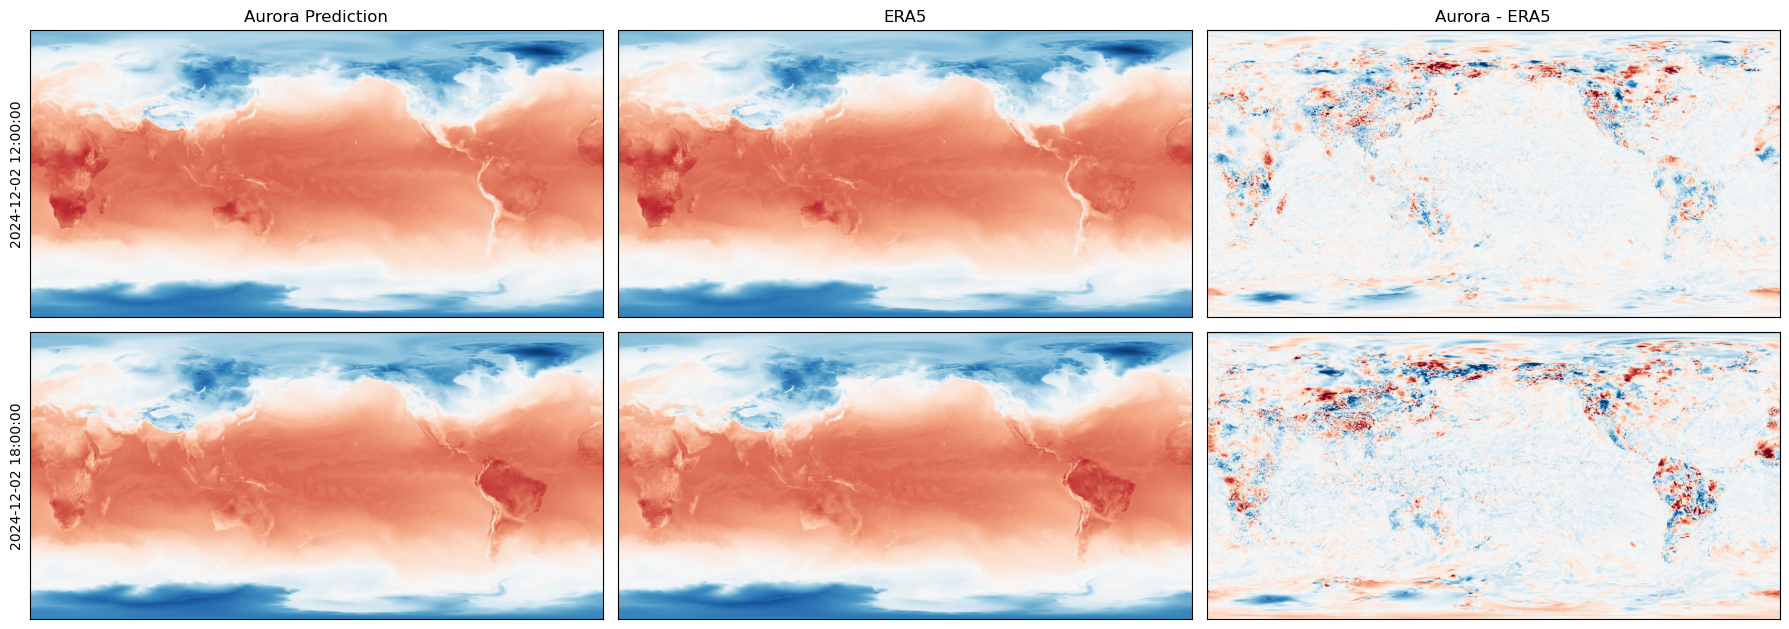

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(18, 6.5))

for i in range(ax.shape[0]):

    ax[i, 0].imshow(np.squeeze(response.as_numpy("surf_vars_2t")[i]) - 273.15, vmin=-50, vmax=50, cmap='RdBu_r')
    ax[i, 0].set_ylabel(str(datetime.fromtimestamp(response.as_numpy("metadata_time")[i])))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50, cmap='RdBu_r')
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    
    ax[i, 2].imshow(np.squeeze(response.as_numpy("surf_vars_2t")[i]) - surf_vars_ds["t2m"][2 + i].values[:-1, :], vmin=-3, vmax=3, cmap='RdBu_r')
    if i == 0:
        ax[i, 2].set_title("Aurora - ERA5")
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])    

plt.tight_layout()